In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold

from main import B2B, score_knockout

In [2]:
np.random.seed(1)

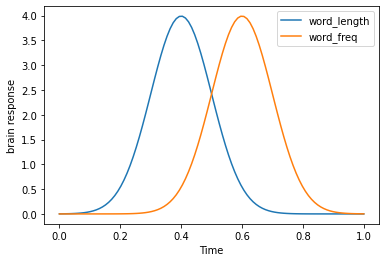

In [3]:
# Many neuroimaging study consist in identifying which factor cause brain activity.
# For example, some primary visual regions may respond proportionally to the size
# of a word (i.e. a low-level feature), whereas secondary areas may respond
# proportionnally to their frequency (i.e. a semantic, and thus high-level feature)
n_times = 100
time = np.linspace(0, 1, n_times)
word_length = norm.pdf(time, .4, .1)
word_freq = norm.pdf(time, .6, .1)
plt.plot(time, word_length, label='word_length')
plt.plot(time, word_freq, label='word_freq')
plt.xlabel('Time')
plt.ylabel('brain response')
plt.legend()

In [4]:
def make_data(snr=1.):
    """Simulate n_words multidimensional brain responses 
    corrupted by background noise"""
    n = 1000  # number of words
    dx = 2  # word length and word frequency
    
    # feature covariance
    Cx = np.random.randn(dx, dx) 
    X = np.random.multivariate_normal(np.zeros(2), Cx, n)  # word features
    X = scale(X)
    
    # forward operator: from source to sensor
    dy = 3
    F = np.random.randn(dy, dy)
    Y = np.zeros((n, dy, n_times))
    for t, (length, freq) in enumerate(zip(word_length, word_freq)):
        Z = np.diag([length, freq])
        source = X @ Z
        # add correlated noise
        noise = np.random.randn(n) / (snr + 1e-7)
        source = np.c_[source, noise]
        # Y is now our multivariate measurement (i.e. sensors)
        Y[:, :, t] = source @ F
        # add sensor noise
        Y[:, :, t] += np.random.randn(n, dy)
        # normalize
        Y[:, :, t] = scale(Y[:, :, t])

    return X, Y

In [5]:
# When the snr is high, forward model are sufficient
X, Ys = make_data(snr=10)
n_words, word_length_and_freq = X.shape
n_words, n_channels, n_times = Ys.shape

model = LinearRegression()
betas = np.zeros((n_times, n_channels, 2))
for t in range(n_times):
    Y = Ys[:, :, t]
    model.fit(X, Y)
    betas[t] = model.coef_

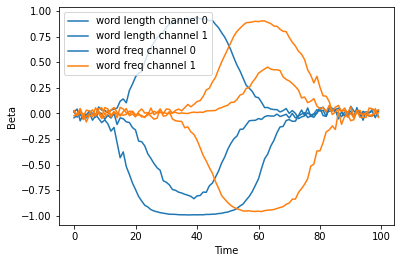

In [6]:
# However, the analysis can rapidly be overwhelming 
# as we need to investigate each brain dimension (here 
# channel) separately
plt.plot(betas[:, :, 0], color='C0')
plt.plot(betas[:, :, 1], color='C1')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend(['word %s channel %i' % (feature, ch) 
            for feature in ('length', 'freq') for ch in range(2)])

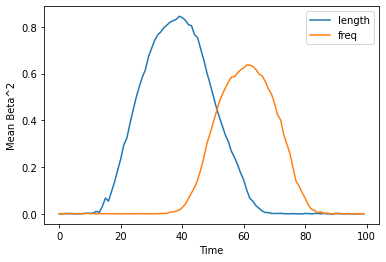

In [7]:
# A straightforward approach is thus to plot the mean beta square
# This retrieves a plausible time course of the main effects
plt.figure()
plt.plot((betas[:, :, 0]**2).mean(1), color='C0', label='length')
plt.plot((betas[:, :, 1]**2).mean(1), color='C1', label='freq')
plt.xlabel('Time')
plt.ylabel('Mean Beta^2')
plt.legend()

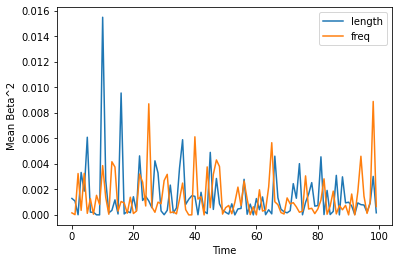

In [8]:
# However, with low signal-to-noise ratio
# these effects can be completely washed out

# When the snr is high, forward model are sufficient
X, Ys = make_data(snr=1e-5)

model = LinearRegression()
betas = np.zeros((n_times, n_channels, 2))
for t in range(n_times):
    betas[t] = model.fit(X, Ys[:, :, t]).coef_

plt.plot((betas[:, :, 0]**2).mean(1), color='C0', label='length')
plt.plot((betas[:, :, 1]**2).mean(1), color='C1', label='freq')
plt.xlabel('Time')
plt.ylabel('Mean Beta^2')
plt.legend()

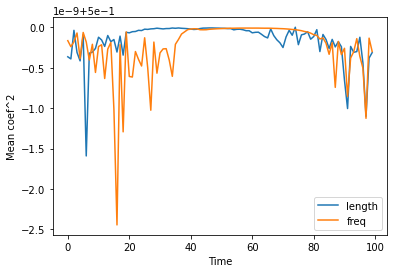

In [9]:
# CCA is not designed to introspect the coefficients
# of each variable but to find the dimension where 
# X and Y are maximally correlated for all variables
# It is thus not straightforward to use it to identify 
# the role of each word dimension on brain activity

n_components = 2
model = CCA(n_components)
H = np.zeros((n_times, n_components, 2))
for t in range(n_times):
    H[t] = model.fit(X, Ys[:, :, t]).x_weights_.T

plt.plot((H[:, :, 0]**2).mean(1), color='C0', label='length')
plt.plot((H[:, :, 1]**2).mean(1), color='C1', label='freq')
plt.xlabel('Time')
plt.ylabel('Mean coef^2')
plt.legend()

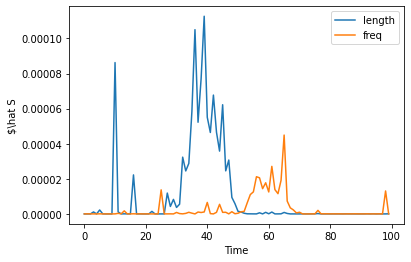

In [10]:
# Here we propose B2B, which is designed to retrieve
# the contribution of each variable (proportional to its SNR)
model = B2B()

S_hat = np.zeros((n_times, n_channels, 2))
for t in range(n_times):
    S_hat[t] = model.fit(X, Ys[:, :, t]).S_

plt.plot((S_hat[:, :, 0]**2).mean(1), color='C0', label='length')
plt.plot((S_hat[:, :, 1]**2).mean(1), color='C1', label='freq')
plt.xlabel('Time')
plt.ylabel('$\hat S')
plt.legend()

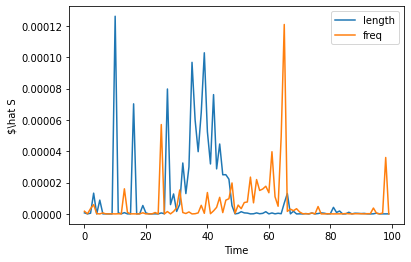

In [11]:
# B2B coefficient are biased by the H operator
# if you need unbiased estimates you can either use
# an unbiased H
# Ensemble for (slower) more robust estimates

model = B2B(H=LinearRegression(), ensemble=10)

S_hat = np.zeros((n_times, n_channels, 2))
for t in range(n_times):
    S_hat[t] = model.fit(X, Ys[:, :, t]).S_

plt.plot((S_hat[:, :, 0]**2).mean(1), color='C0', label='length')
plt.plot((S_hat[:, :, 1]**2).mean(1), color='C1', label='freq')
plt.xlabel('Time')
plt.ylabel('$\hat S')
plt.legend()

In [12]:
# Or use a knock-out evaluation procedure

Text(0, 0.5, 'R')

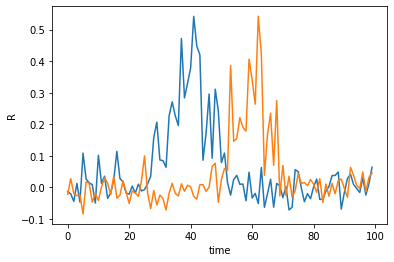

In [13]:
model = B2B(ensemble=None)
r = np.zeros((n_times, 2))
cv = KFold(5)
for t in range(n_times):
    Y = Ys[:, :, t]
    for train, test in cv.split(X, Y):
        model.fit(X[train], Y[train])
        r[t] += score_knockout(model, X[test], Y[test])
plt.plot(r/cv.n_splits)
plt.xlabel('time')
plt.ylabel('R')